In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Data Notes
* File: Bicycle Thefts 1/1/2010 - 9/16/2013 CSV
* Used http://metadata.phila.gov/#home/datasetdetails/5543868920583086178c4f8e/representationdetails/55438adc9b989a05172d0d95/ for columns
    * bike set didn't seem to have one loading for me
* Columns
    * DC Number = District Number
    * DC Key = The unique identifier of the crime that consists of Year + District + Unique ID.
    * Location = Location the theft occured at
    * Theft Date = Date of Theft
    * Theft Year = The year that the theft occured
    * District = The Philadelphia district where the theft occured
    * Stolen Value = The value amount in dollars of the bike
    * Theft Hour = Hour of the day in military time that the bike theft occured
    * UCR = The rounded crime code, i.e. 614 to 635, of the bike theft.
        * From http://www.phillypolice.com/assets/directives/D12.11-ComplaintOrIncidentReport.pdf
            * 615 = "THEFT - 200 and over"
            * 625 = "THEFT - 50 to 199.99"
            * 635 = "THEFT - Under 50 (Include Attempts)"
    * Latitude
    * Longitude
    * Location 1 = (Latitude, Longitude)

##### Load the Data into a Dataframe

In [2]:
df = pd.read_csv('Bicycle_Thefts.csv')

In [3]:
df.shape # rows, cols

(7223, 12)

##### Take a Look Around
* It helps me get a sense of the data, in terms of values, data types, possibly low variance / ineffective features, by looking at a few rows before I dive in

In [4]:
df.head()

,DC Number,DC Key,Location,Theft Date,Theft Year,District,Stolen Value,Theft Hour,UCR,Latitude,Longitude,Location 1
0,14848,201001000000,2100 BLOCK S BROAD ST,04/16/2010 12:00:00 AM,2010,1,150,0,625,39.924273,-75.169775,"(39.9242733, -75.16977545)"
1,16330,201001000000,S 2100 MCKEAN ST,04/24/2010 12:00:00 AM,2010,1,215,17,615,39.927074,-75.180905,"(39.9270745, -75.1809054)"
2,23568,201001000000,2700 BLOCK SNYDER AVE,06/06/2010 12:00:00 AM,2010,1,120,11,625,39.927120,-75.191034,"(39.9271197, -75.19103415)"
3,28556,201001000000,2100 BLOCK S GARNET ST,07/08/2010 12:00:00 AM,2010,1,200,15,615,39.925411,-75.178257,"(39.9254113, -75.17825736)"
4,29047,201001000000,2100 BLOCK S 15TH ST,07/11/2010 12:00:00 AM,2010,1,75,11,625,39.924141,-75.171457,"(39.9241409, -75.17145694)"


##### Feature Creation
* No month or day column, but we have hour and year, so let's create it to be thorough
* I will iterate through every row in Theft Date, and assign a value in the new column created (Month or Day) based off of the transformation I make.
* The apply method is a much faster way of assigning the values compared to looping

In [5]:
from dateutil import parser
df['Theft Month'] = df['Theft Date'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
df['Theft Day'] = df['Theft Date'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p'))
df['Theft Month'] = df['Theft Month'].apply(lambda x: datetime.datetime.strftime(x,'%m'))
df['Theft Day'] = df['Theft Day'].apply(lambda x: datetime.datetime.strftime(x,'%d'))


##### Reorder the columns - Now let's reorder the dataframe so the dates are grouped nicely together

In [7]:
cols = list(df)
# move the column to the location we want using index, pop and insert
cols.insert(4, cols.pop(cols.index('Theft Month')))
cols.insert(4, cols.pop(cols.index('Theft Day')))
cols.insert(4, cols.pop(cols.index('Theft Hour')))
df = df.ix[:, cols]
df.head()

,DC Number,DC Key,Location,Theft Date,Theft Hour,Theft Day,Theft Month,Theft Year,District,Stolen Value,UCR,Latitude,Longitude,Location 1
0,14848,201001000000,2100 BLOCK S BROAD ST,04/16/2010 12:00:00 AM,0,16,04,2010,1,150,625,39.924273,-75.169775,"(39.9242733, -75.16977545)"
1,16330,201001000000,S 2100 MCKEAN ST,04/24/2010 12:00:00 AM,17,24,04,2010,1,215,615,39.927074,-75.180905,"(39.9270745, -75.1809054)"
2,23568,201001000000,2700 BLOCK SNYDER AVE,06/06/2010 12:00:00 AM,11,06,06,2010,1,120,625,39.927120,-75.191034,"(39.9271197, -75.19103415)"
3,28556,201001000000,2100 BLOCK S GARNET ST,07/08/2010 12:00:00 AM,15,08,07,2010,1,200,615,39.925411,-75.178257,"(39.9254113, -75.17825736)"
4,29047,201001000000,2100 BLOCK S 15TH ST,07/11/2010 12:00:00 AM,11,11,07,2010,1,75,625,39.924141,-75.171457,"(39.9241409, -75.17145694)"


##### Create new dataframe with Columns I want to drill down into

In [8]:
time_df = df[['Location','Theft Date','Theft Hour','Theft Day','Theft Month'
              ,'Theft Year','District','Stolen Value','UCR']]

##### Set plot parameters before we get started

In [9]:
rcParams['figure.figsize'] = (20, 8)
rcParams['figure.dpi'] = 300

# Let's Explore the Data

### Theft Date 
* aka the date on which a bike theft occured


In [10]:
time_df['Theft Date'] = pd.to_datetime(pd.Series(time_df['Theft Date']))
time_df.set_index('Theft Date', drop=False, inplace=True)

time_df['Total Thefts on Date'] = time_df['Theft Date'].value_counts()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# print time_df['Total Thefts on Date'].value_counts()[:5] # How many dates have 8 thefts
# print 
# print time_df['Total Thefts on Date'][:5] # Thefts on a given date

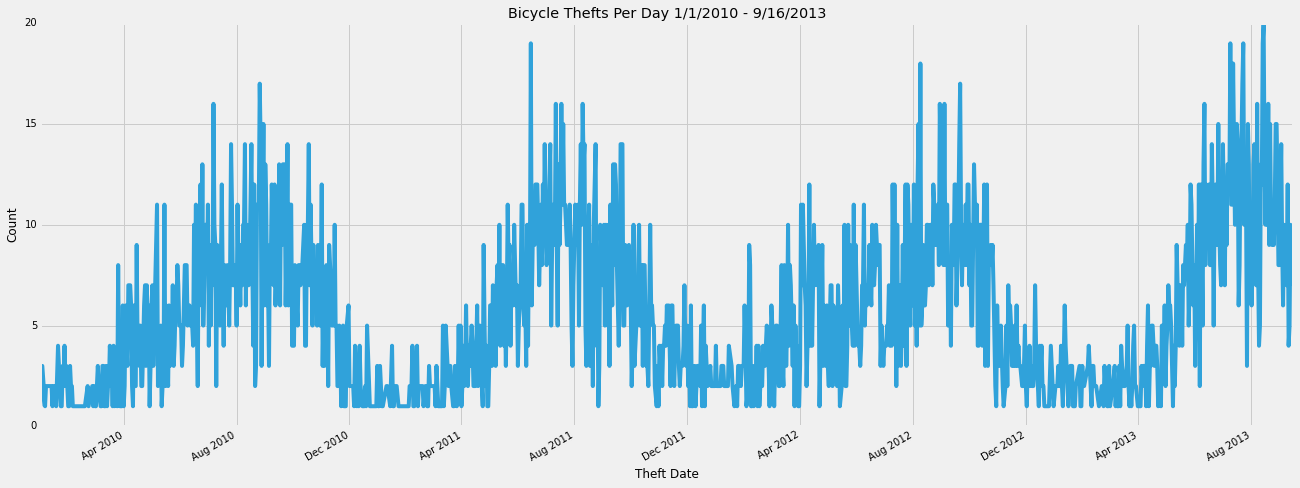

In [15]:
with plt.style.context('fivethirtyeight'):
    plt.show()
    plt.figure()
    plt.ylim(0,20)
    plt.title("Bicycle Thefts Per Day 1/1/2010 - 9/16/2013", loc="Center")
    plt.ylabel('Count')
    time_df['Total Thefts on Date'].plot(x_compat=True)

* You can see a few data points that stick out. Let's take a look at the one with the largest value

In [16]:
worst_day = time_df.loc[time_df['Total Thefts on Date'].idxmax()]
worst_day.head()

,Location,Theft Date,Theft Hour,Theft Day,Theft Month,Theft Year,District,Stolen Value,UCR,Total Thefts on Date
Theft Date,,,,,,,,,,
2013-08-15,S 08TH ST / PIERCE ST,2013-08-15,0,15,08,2013,3,135,625,20
2013-08-15,N 09TH ST / MARKET ST,2013-08-15,16,15,08,2013,6,120,625,20
2013-08-15,200 BLOCK S 12TH ST,2013-08-15,23,15,08,2013,6,2000,615,20
2013-08-15,1600 BLOCK MOUNT VERNON ST,2013-08-15,17,15,08,2013,9,1150,615,20
2013-08-15,200 BLOCK N 23RD ST,2013-08-15,17,15,08,2013,9,2290,615,20


In [17]:
print worst_day.describe()
print
print "The most commmon District for theft on this day was the %dth district"%worst_day['District'].mode()
print "The most commmon Hour for theft on this day was %d00"%worst_day['Theft Hour'].mode()
print "The Median for theft value on this day was the %d"%worst_day['Stolen Value'].median()

       Theft Hour  Theft Year   District  Stolen Value         UCR  \
count   20.000000          20  20.000000     20.000000   20.000000   
mean    14.600000        2013  12.450000    486.750000  619.000000   
std      4.783744           0   7.052249    627.390743    5.026247   
min      0.000000        2013   3.000000     70.000000  615.000000   
25%     13.750000        2013   7.500000    120.000000  615.000000   
50%     15.000000        2013   9.000000    200.000000  615.000000   
75%     17.000000        2013  18.000000    425.000000  625.000000   
max     23.000000        2013  25.000000   2290.000000  625.000000   

       Total Thefts on Date  
count                    20  
mean                     20  
std                       0  
min                      20  
25%                      20  
50%                      20  
75%                      20  
max                      20  

The most commmon District for theft on this day was the 9th district
The most commmon Hour for the

##### Notes:
* The worst day of the year in our dataset for bike theft was August 15th, 2013.
    * 20 thefts that day
    * The average value of a bike stolen was 486 dollars and the median was 200 dollars so we're a bit positively skewed. There are some data points pushing our mean to the right, but most bikes that were stolen that day were ~200 dollars.
    * 9 out of 20 happened in Districts 9 and 6
        * The most commmon District for theft on this day was the 9th district
    * 50% of them occured between 3pm and 6pm
    * The mean hour is 2pm (1400 hours), and only 25% of thefts happened before 2pm (5 thefts)
    * The first theft occured between 0-1am and the last theft occured between 11-12pm that night
* Data is very seasonal as you can see theft increases as we move towards the summer and falls in the dead of winter

### Theft Year
* aka the year that a theft occured

In [18]:
# time_df.set_index('Theft Date', drop=False, inplace=True)
thefts_yearly = time_df['Theft Year'].value_counts()
thefts_yearly = pd.DataFrame(thefts_yearly)
thefts_yearly.columns = ['Thefts Per Year']
thefts_yearly

,Thefts Per Year
2012,1975
2011,1848
2010,1831
2013,1569


* We are missing October through December for 2013, so let's estimate and complete 2013
* I'm going to take the monthly average for the 9 complete months of 2013 data, then multiply it by 3 to get an estimated total for the last 3 months. I'll then add that onto the current total.

In [19]:
thefts_yearly.values[3] = (((thefts_yearly.values[3]/9)*3)+thefts_yearly.values[3])

In [20]:
thefts_yearly.reset_index()
thefts_yearly["Thefts Per Year"]

2012    1975
2011    1848
2010    1831
2013    2091
Name: Thefts Per Year, dtype: int64

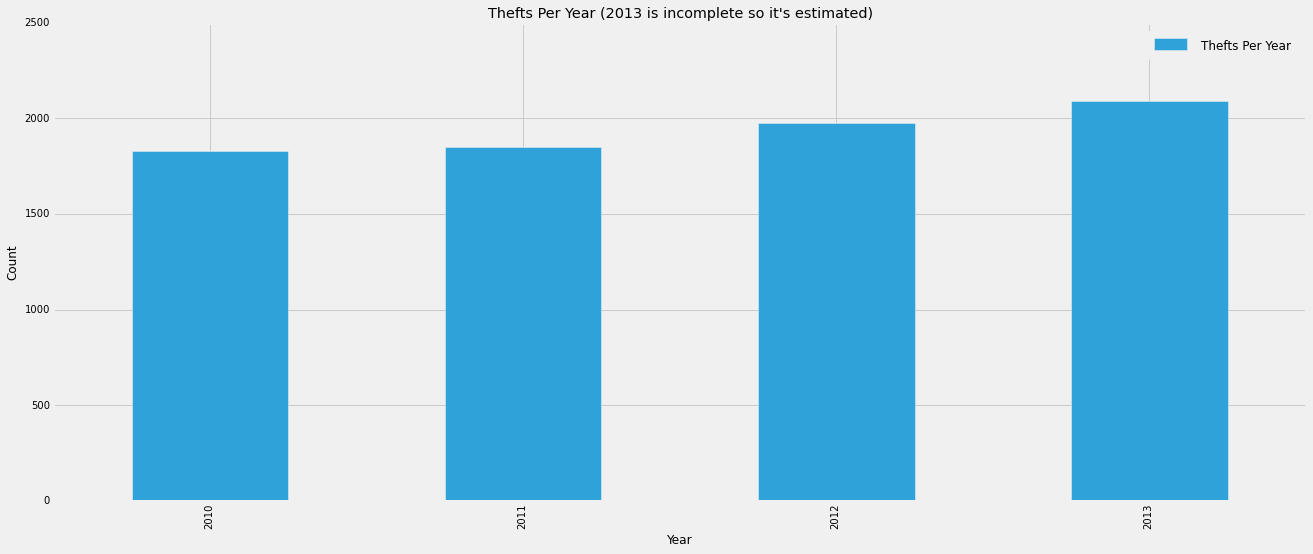

In [21]:
with plt.style.context('fivethirtyeight'):
    ax = thefts_yearly.sort_index().plot(kind='bar')
    ax.set_title("Thefts Per Year (2013 is incomplete so it's estimated)")
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")

##### Quick math to get the percent increase per year and avg

In [22]:
x1 = ((2091*1.0/1975)*100)-100
x2 =  ((1975*1.0/1848)*100)-100
x3 = ((1848*1.0/1831)*100)-100
(x1+x2+x3)/3

4.558055496772667

##### Notes:
    * Thefts are increasing each year, at a clip of 4.5%

### Theft Month
* aka the month that a theft occured


* We have an incomplete year, so we can either take monthly averages, or limit the range of months to Sept
* Removing data for that reason is generally a bad idea, so we'll just take monthly averages

In [23]:
thefts_monthly = time_df.groupby(['Theft Year','Theft Month']).size().reset_index().groupby('Theft Month')[[0]].mean()
print "Avg. Monthly Thefts"
print
print thefts_monthly
thefts_monthly.columns = ['Avg Monthly Thefts']

Avg. Monthly Thefts

                  0
Theft Month        
01            44.25
02            45.25
03            76.25
04           123.75
05           174.50
06           236.75
07           283.00
08           295.50
09           239.25
10           152.00
11            89.75
12            45.50


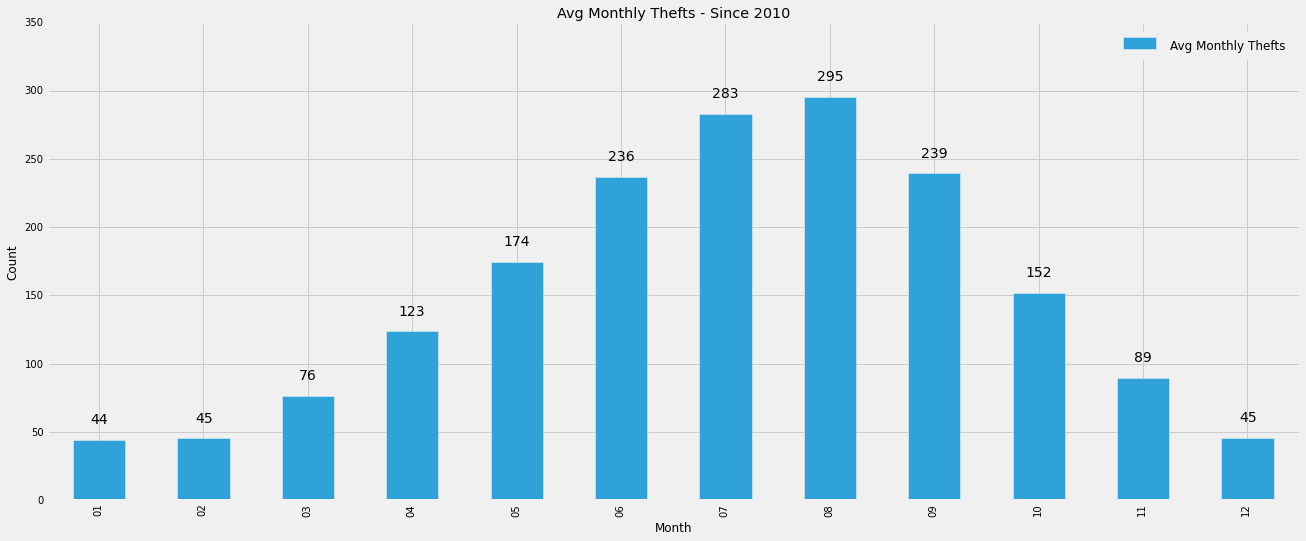

In [24]:
with plt.style.context('fivethirtyeight'):
    ax = thefts_monthly.plot(kind='bar')
    # ax = thefts_monthly["Total Thefts on Date"].mean().sort_index().plot(kind='bar')
    ax.set_title("Avg Monthly Thefts - Since 2010")
    ax.set_xlabel("Month")
    ax.set_ylabel("Count")
    plt.ylim(0,350)
    values = thefts_monthly['Avg Monthly Thefts'].astype(int)
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+10, label, ha='center', va='bottom')

In [28]:
thefts_monthly.describe()

,Avg Monthly Thefts
count,12.000000
mean,150.479167
std,94.284836
min,44.250000
25%,68.562500
50%,137.875000
75%,237.375000
max,295.500000


##### Notes:
* So many bikes are stolen during the summer, when most people ride their bikes or keep them outside.
    * Further analysis could be done by joining weather data or indego bike data.  It'd be interesting to see if indego monthly bike volume correlates with our theft volume data. I don't know if that's ever been done, whereas correlating weather to violence/crime/etc has been researched a fair amount
* ~45% of total yearly amount are stolen in the summer months (June, July, and August) - if it were equal it'd be 25%

### Theft Day
* aka the day of the month a theft occurs

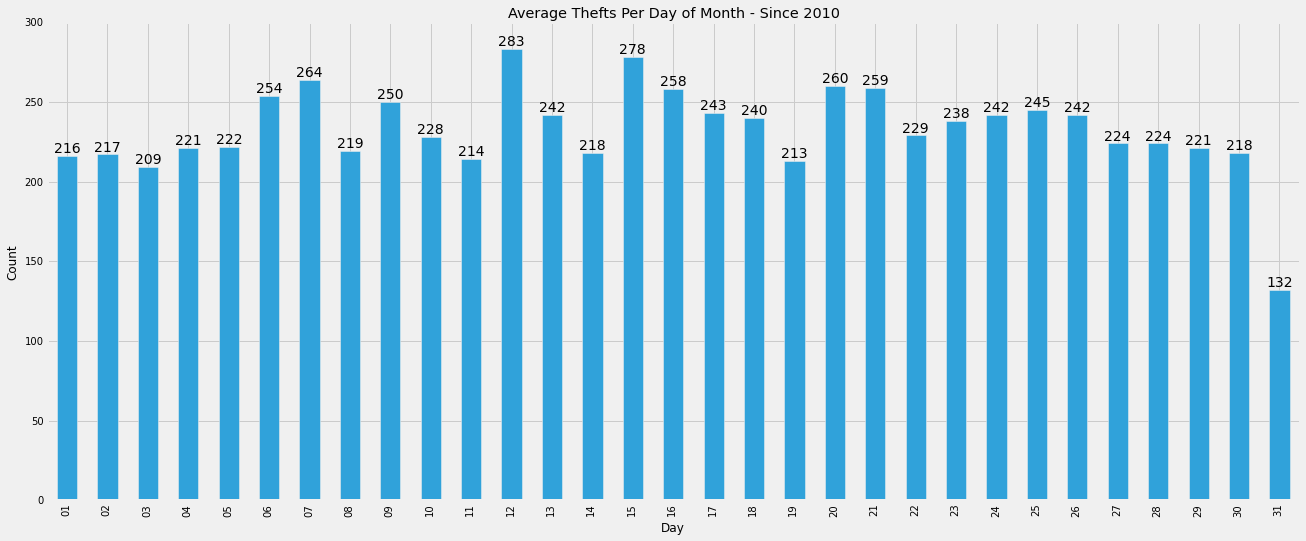

In [29]:
with plt.style.context('fivethirtyeight'):
    thefts_daily = time_df.groupby(time_df['Theft Day'])
    thefts_daily["Total Thefts on Date"].count()
    ax = thefts_daily["Total Thefts on Date"].count().sort_index().plot(kind='bar')
    ax.set_title("Average Thefts Per Day of Month - Since 2010")
    ax.set_xlabel("Day")
    ax.set_ylabel("Count")
    values = thefts_daily["Total Thefts on Date"].count()
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [30]:
thefts_daily["Total Thefts on Date"].count().describe()

count     31.000000
mean     233.000000
std       27.171063
min      132.000000
25%      218.500000
50%      229.000000
75%      247.500000
max      283.000000
Name: Total Thefts on Date, dtype: float64

In [31]:
print ("High Outlier Hours: %f"% (np.average(thefts_daily["Total Thefts on Date"].count())
                                  +((np.std(thefts_daily["Total Thefts on Date"].count()))*2)))
print ("Low Outlier Hours: %f"% (np.average(thefts_daily["Total Thefts on Date"].count())
                                 -((np.std(thefts_daily["Total Thefts on Date"].count()))*2)))

High Outlier Hours: 286.458455
Low Outlier Hours: 179.541545


##### Notes:
    * The end of the month sees a lower amount of theft than normal, with the 31st being the outlier
    * The middle of the month, namely the 12th and the 15th, see the most thefts
    * Standard Deviation is an order of magnitude smaller than the mean, so the data isn't spread out all that much

### Theft Hourly
* aka the hour of the day that most thefts occur

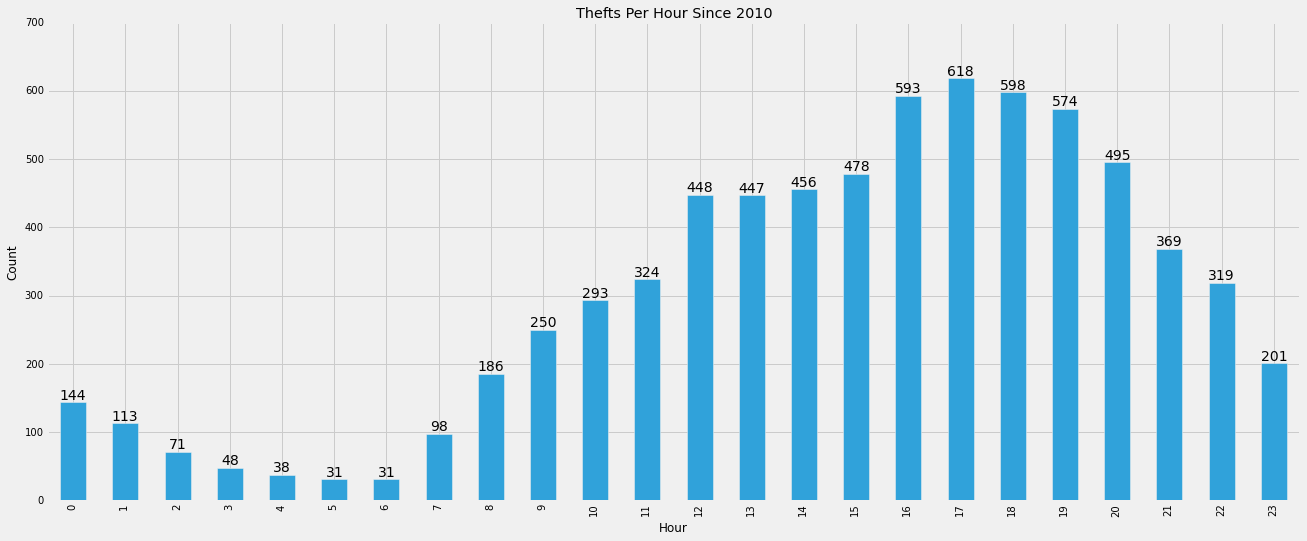

In [33]:
with plt.style.context('fivethirtyeight'):
    thefts_hourly = time_df.groupby(time_df['Theft Hour']).count()
    # ax = thefts_hourly["Thefts"].mean().plot(kind='bar')
    ax = thefts_hourly['Total Thefts on Date'].plot(kind='bar')
    ax.set_title("Thefts Per Hour Since 2010")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Count")
    # plt.ylim(0,11)
    values = thefts_hourly['Total Thefts on Date']
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [34]:
thefts_hourly_avg = time_df.groupby(['Theft Year','Theft Hour']).size().reset_index().groupby('Theft Hour')[[0]].mean()
# print "Avg. Hourly Thefts"
print
# print thefts_monthly
thefts_hourly_avg.columns = ['Avg Hourly Thefts']

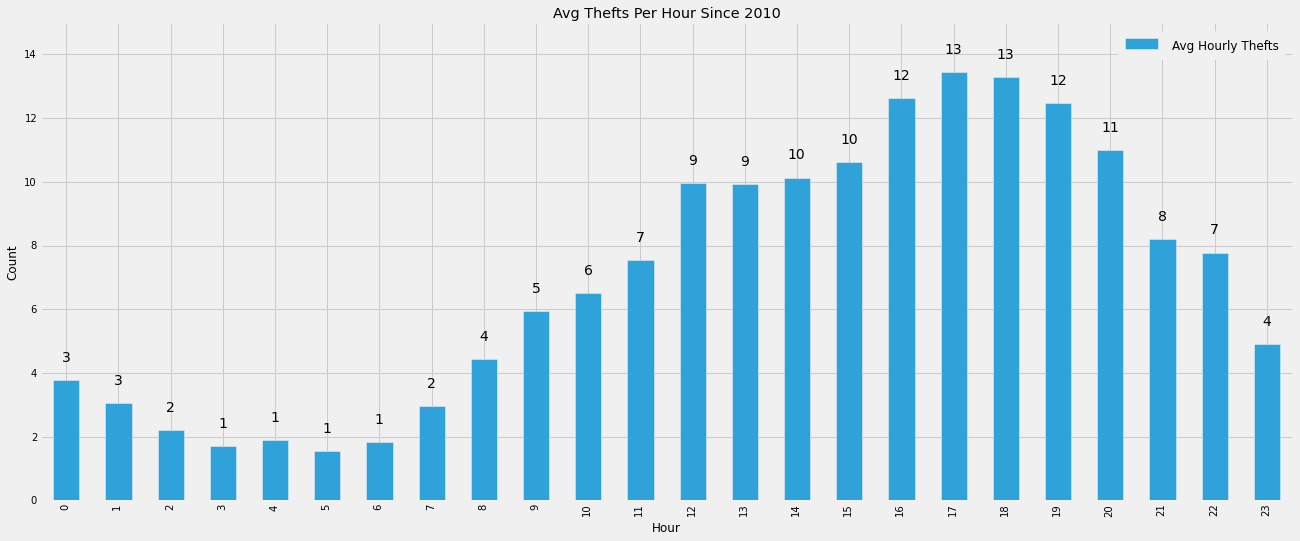

In [37]:
with plt.style.context('fivethirtyeight'):
    thefts_hourly_avg = time_df.groupby(['Theft Year','Theft Month','Theft Hour']).size().reset_index().groupby('Theft Hour')[[0]].mean()
    thefts_hourly_avg.columns = ['Avg Hourly Thefts']
    # ax = thefts_hourly["Thefts"].mean().plot(kind='bar')
    ax = thefts_hourly_avg.plot(kind='bar')
    ax.set_title("Avg Thefts Per Hour Since 2010")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Count")
    plt.ylim(0,15)
    values = thefts_hourly_avg['Avg Hourly Thefts'].astype(int)
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [38]:
print ("High Outlier Hours: %f"% (np.average(thefts_hourly_avg['Avg Hourly Thefts'].astype(int))
                                  +((np.std(thefts_hourly_avg['Avg Hourly Thefts'].astype(int)))*2)))
print ("Low Outlier Hours: %f"% (np.average(thefts_hourly_avg['Avg Hourly Thefts'].astype(int))
                                 -((np.std(thefts_hourly_avg['Avg Hourly Thefts'].astype(int)))*2)))

High Outlier Hours: 14.640953
Low Outlier Hours: -1.807620


##### Notes:
    * There are no outliers for this data
    * A large amount of bike thefts occur between 3-8pm
        * You see the minimum at sun up, increasing throughout the day until sun down essentially
    * Bike theives sleep too

### Thefts per District
* the district that most thefts occur

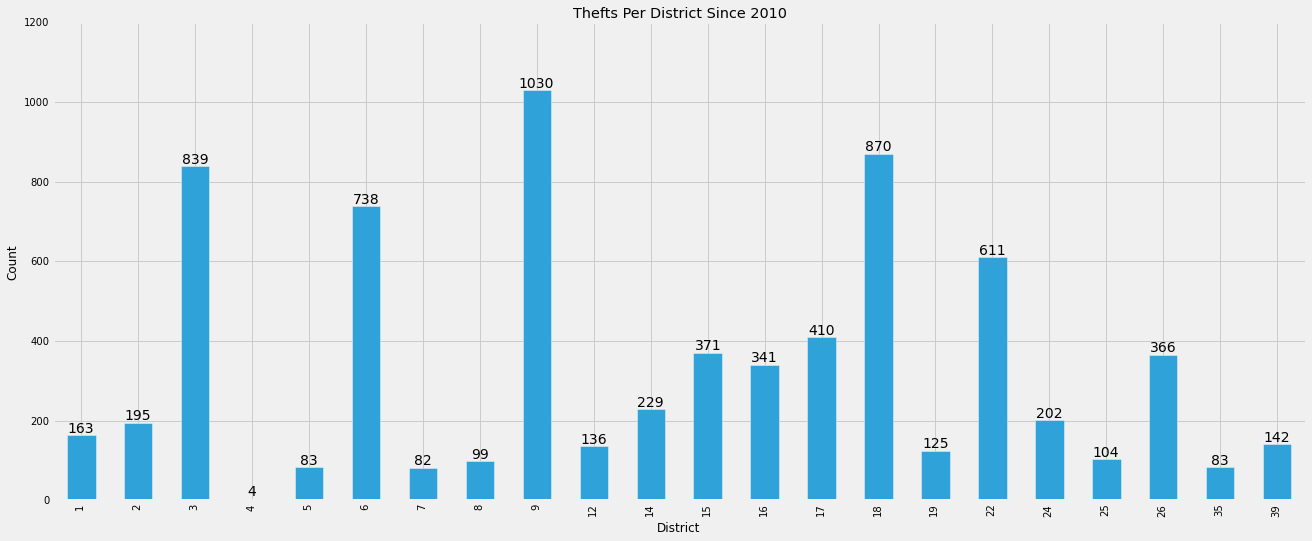

In [40]:
with plt.style.context('fivethirtyeight'):
    thefts_district = time_df.groupby(time_df['District']).count()
    ax = thefts_district['Total Thefts on Date'].plot(kind='bar')
    ax.set_title("Thefts Per District Since 2010")
    ax.set_xlabel("District")
    ax.set_ylabel("Count")
    # plt.ylim(0,11)
    values = thefts_district['Total Thefts on Date']
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [41]:
# change to count?
# thefts_district["Thefts"].aggregate(np.sum).describe()
len(time_df)
# time_df.groupby(time_df['District']).count().sum()
time_df.groupby(time_df['District'])['Total Thefts on Date'].count().describe()

count      22.000000
mean      328.318182
std       299.004760
min         4.000000
25%       109.250000
50%       198.500000
75%       400.250000
max      1030.000000
Name: Total Thefts on Date, dtype: float64

In [42]:
print ("High Outlier Hours: %f"% (np.average(thefts_district['Total Thefts on Date'])
                                  +((np.std(thefts_district['Total Thefts on Date']))*2)))
print ("Low Outlier Hours: %f"% (np.average(thefts_district['Total Thefts on Date'])
                                 -((np.std(thefts_district['Total Thefts on Date']))*2)))

High Outlier Hours: 912.578518
Low Outlier Hours: -255.942154


##### Notes:
* If you take 2 Standard Deviationss as an outlier, only District 9 meets the requirement for upper bound outliers.
* Clearly District 9 is far above the rest of the field, but the average is 328 and the median is 198. This means that the data is positively skewed. 
* Also pretty clear, District 4 is a good place to lock up your bike if you want it to be safe.
* Finally, to generalize you can say that the middle 50 percent of districts have seen anywhere from 109 to 400 bikes stolen in the range of data that we have.

### Thefts By UCR (Basically Bins Stolen Values into 3)

aka the number of thefts grouped by the value of the bike.
* Reminder: UCR = The rounded crime code, i.e. 614 to 635, of the bike theft.
    * From http://www.phillypolice.com/assets/directives/D12.11-ComplaintOrIncidentReport.pdf
        * 615 = "THEFT - 200 and over"
        * 625 = "THEFT - 50 to 199.99"
        * 635 = "THEFT - Under 50 (Include Attempts)"

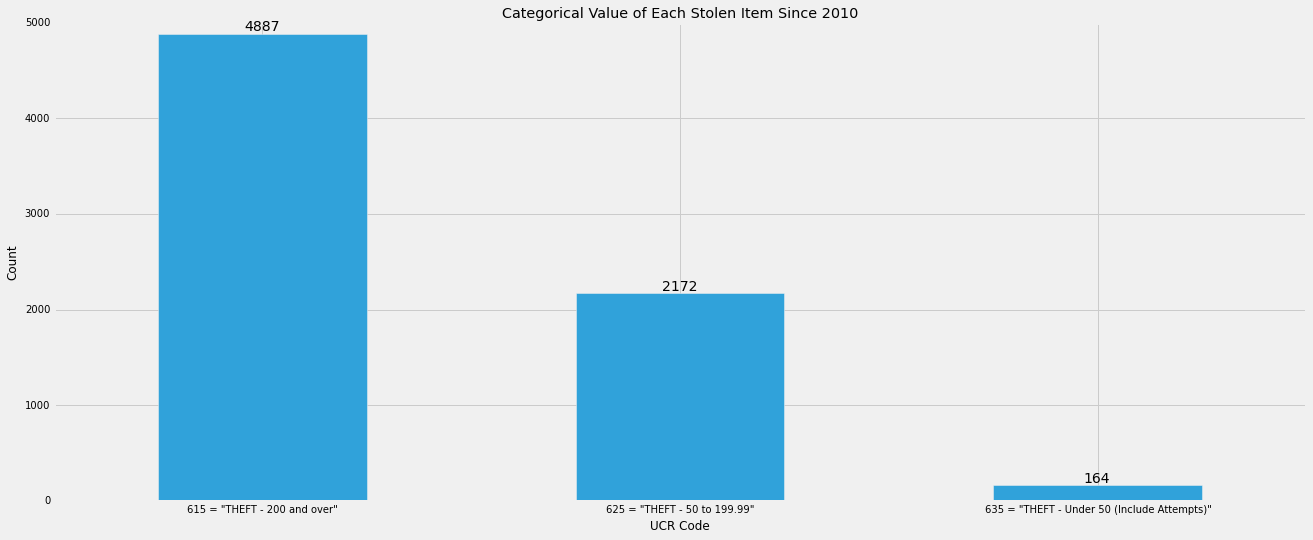

In [44]:
with plt.style.context('fivethirtyeight'):
    thefts_ucr = time_df.groupby(time_df['UCR']).size()
    ax = thefts_ucr.plot(kind='bar')
    ax.set_title("Categorical Value of Each Stolen Item Since 2010")
    ax.set_xlabel("UCR Code")
    ax.set_ylabel("Count")
    # plt.ylim(0,11)
    values = time_df.groupby(time_df['UCR']).size()
    labels = [i for i in values]
    rects = ax.patches
    coding = ['615 = "THEFT - 200 and over"',
    '625 = "THEFT - 50 to 199.99"','635 = "THEFT - Under 50 (Include Attempts)"']
    codes = [item.get_text() for item in ax.get_xticklabels()]
    codesx = [i for i in coding]
    ax.set_xticklabels(codesx, rotation='horizontal')

    # plt.xticks(labels,codes, rotation='vertical')
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

##### Notes:

* Most bikes stolen are valued at 200 or more (2/3 of the total bikes stolen).
* One can assume that most bikes that are stolen are also newer, as price depreciates with time since purchase
* One can also postulate that most bike thefts are successful, as only 165 thefts of a bike valued at 50 or lower or attempted thefts have been recorded

### Location
* aka the number of thefts per location

* Not expecting much from counting location data as there shouldn't be very many repeat offenses if you think about it.  That means the police aren't doing their jobs and or people aren't learning
* Going to take the top 20 places, just to keep it manageable in graph form

In [45]:
time_df.groupby(time_df['Location']).size().sum()
print "There are %d unique locations in the dataset & %d instances of theft in total"%\
(time_df.groupby(time_df['Location']).size().count(),time_df.groupby(time_df['Location']).size().sum())

There are 4374 unique locations in the dataset & 7223 instances of theft in total


In [46]:
# thefts_location["Thefts"].aggregate(np.sum)[:20]
thefts_location = time_df.groupby(time_df['Location']).size().sort_values(ascending=False)
thefts_location = thefts_location[:20]
thefts_location

Location
1500 BLOCK MARKET ST      28
200 BLOCK S BROAD ST      27
200 BLOCK S 33RD ST       24
1700 BLOCK N 10TH ST      22
200 BLOCK S JUNIPER ST    21
1900 BLOCK VINE ST        20
3100 BLOCK MARKET ST      20
200 BLOCK N 34TH ST       20
900 BLOCK SOUTH ST        19
1800 BLOCK WALNUT ST      18
3700 BLOCK WALNUT ST      18
1100 BLOCK FILBERT ST     18
200 BLOCK S 34TH ST       17
3900 BLOCK WALNUT ST      17
1600 BLOCK CHESTNUT ST    17
1100 BLOCK S BROAD ST     17
3400 BLOCK SPRUCE ST      17
3900 BLOCK LOCUST WALK    16
1600 BLOCK WALNUT ST      15
1800 BLOCK N 10TH ST      15
dtype: int64

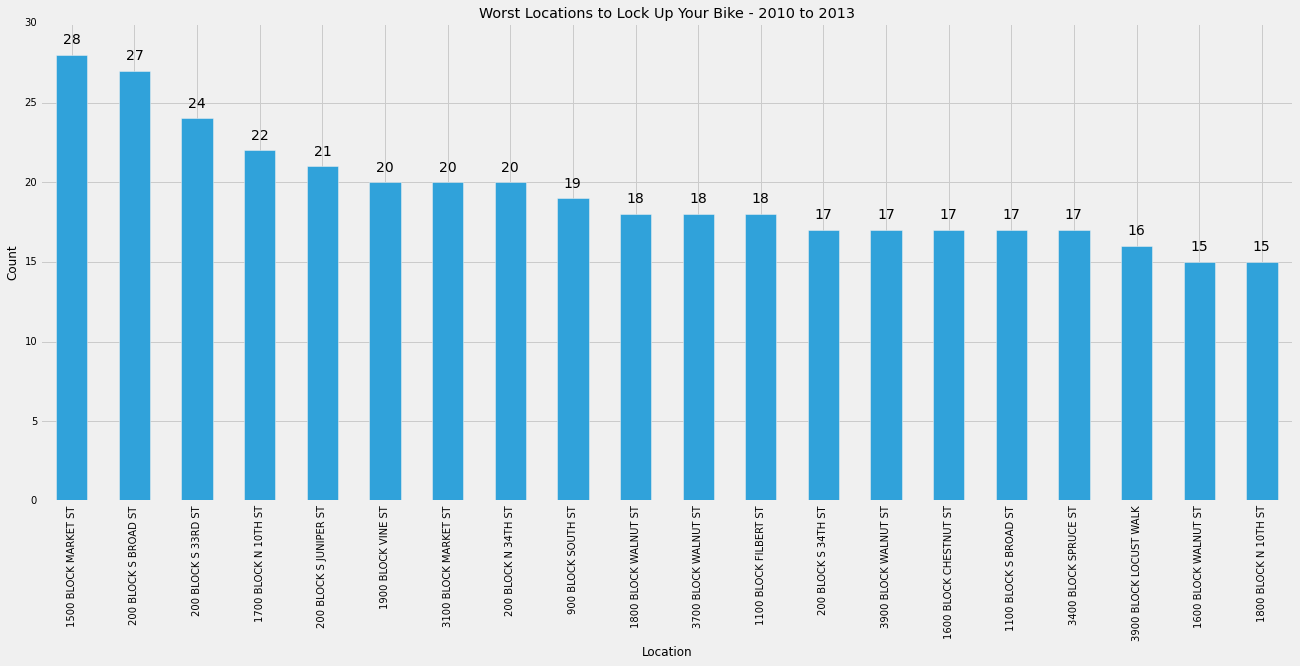

In [48]:
with plt.style.context('fivethirtyeight'):
# thefts_location = time_df.groupby(time_df['Location'])
    ax = thefts_location.plot(kind='bar')
    ax.set_title("Worst Locations to Lock Up Your Bike - 2010 to 2013")
    ax.set_xlabel("Location")
    ax.set_ylabel("Count")
    # plt.ylim(0,11)
    values = time_df.groupby(time_df['Location']).size().sort_values(ascending=False)
    values = values[:20]
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [49]:
time_df.groupby(time_df['Location']).size().describe(percentiles=(.25,.5,.7,.75,.9,.95))

count    4374.000000
mean        1.651349
std         1.878380
min         1.000000
25%         1.000000
50%         1.000000
70%         1.000000
75%         2.000000
90%         3.000000
95%         4.000000
max        28.000000
dtype: float64

##### Notes:
* Protect these places better, change the our strategy for bike protection.
    * Enforce stronger, try to increase public awareness, etc
* As stated above, there are 4374 unique locations in the dataset & 7223 instances of theft in total.
* More than 70% of locations logged have only had 1 bike stolen.
    * This leads me to believe, and the data above supports this, that there are a select number of locations that serve as a more successful opportunity for bike theft than others

### Wordcloud for Locations

In [50]:
from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import wordcloud

##### Get a big string of words from the location row
* We will then be able to tokenize the text and count the number of occurences of each word
* Finally, tokenization allows us to transform text into a feature vector for fast computation in high dimensional spaces

In [51]:
loc_text = time_df['Location'].str.cat(sep=' ')

##### Create a wordcloud from it

In [52]:

# pa_mask = imread("2000px-Keystone_state_symbol_Pennsylvania.svg.png")
pa_mask = imread("philly_skyline.png")
 
wc = wordcloud.WordCloud(background_color="white", max_words=2000, mask=pa_mask)
# generate word cloud
wc.generate(loc_text)

# # store to file
# wc.to_file("pa_word_cloud.png")
wc.to_file("philly_word_cloud.png")


##### Show said wordcloud

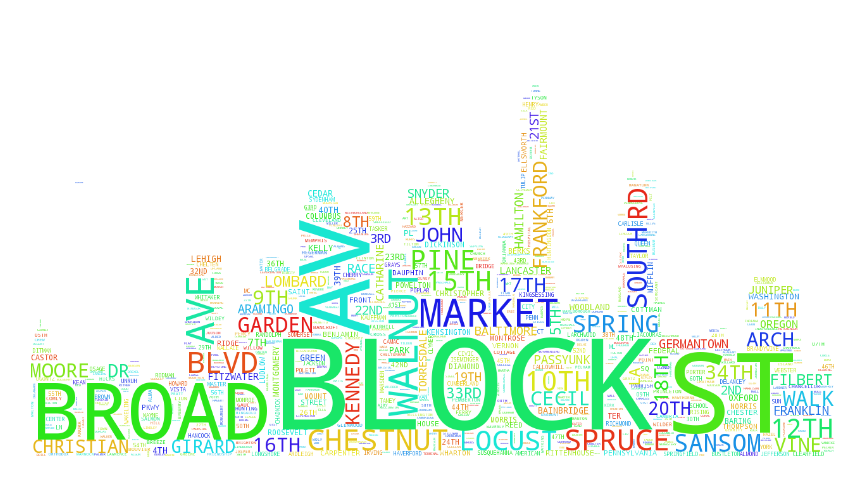

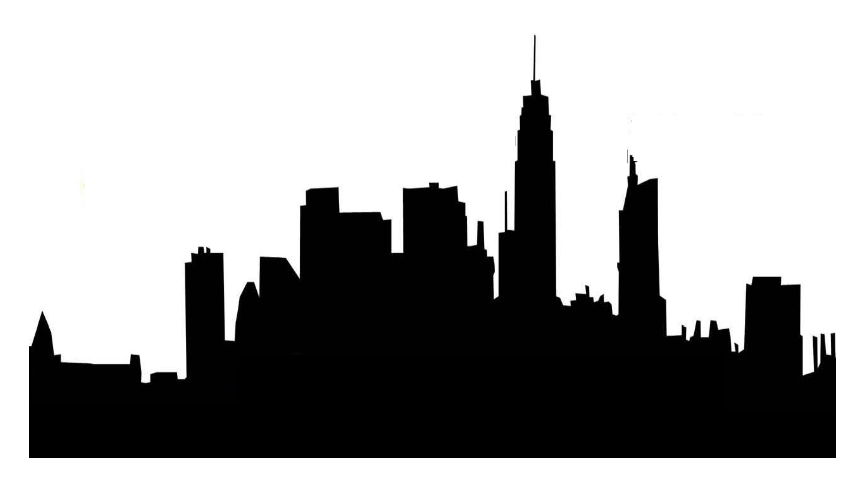

In [53]:
# # show
plt.imshow(wc)
plt.axis("off")
plt.figure()
plt.imshow(pa_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

### Theft Value

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


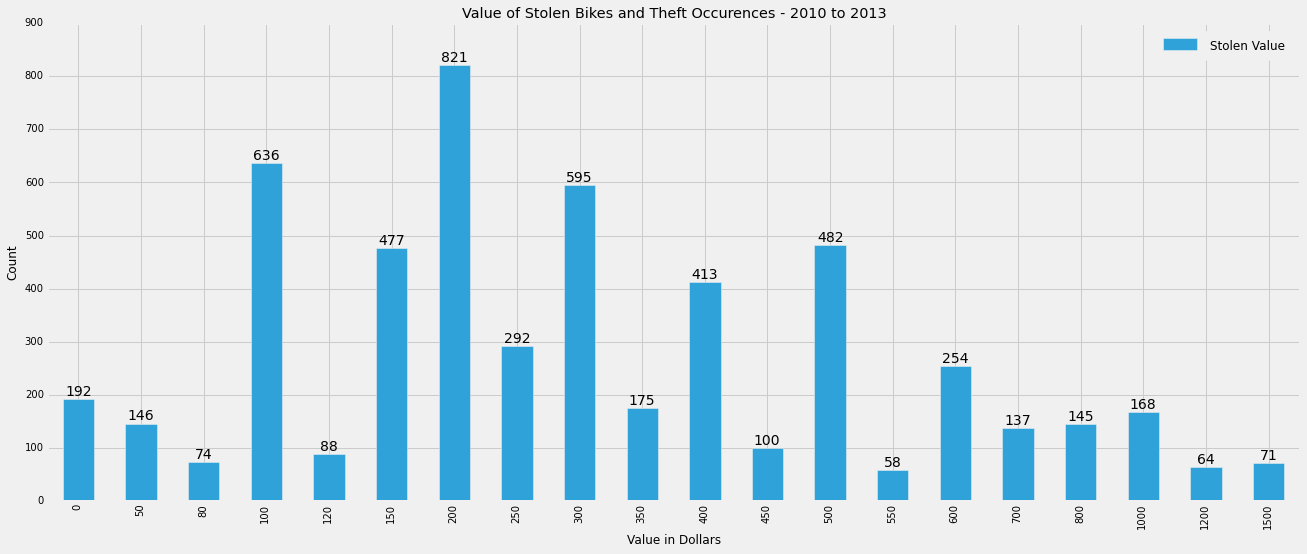

In [55]:
with plt.style.context('fivethirtyeight'):
    stolen = time_df['Stolen Value'].value_counts()[:20].reset_index().sort(["index","Stolen Value"],ascending=[True,False])
    ax = stolen.plot(x='index', y='Stolen Value', kind='bar')
    ax.set_title("Value of Stolen Bikes and Theft Occurences - 2010 to 2013")
    ax.set_xlabel("Value in Dollars")
    ax.set_ylabel("Count")
    values = stolen['Stolen Value']
    # # values = values[:20]
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

In [56]:
df.loc[df['Stolen Value'].idxmax()]

DC Number                           61328
DC Key                       201114000000
Location        7800 BLOCK GERMANTOWN AVE
Theft Date         08/18/2011 12:00:00 AM
Theft Hour                             13
Theft Day                              18
Theft Month                            08
Theft Year                           2011
District                               14
Stolen Value                         7500
UCR                                   615
Latitude                           40.069
Longitude                        -75.1991
Location 1       (40.06903, -75.19909824)
Name: 5791, dtype: object

In [57]:
time_df['Stolen Value'].describe()

count    7223.000000
mean      400.429046
std       470.481895
min         0.000000
25%       150.000000
50%       250.000000
75%       500.000000
max      7500.000000
Name: Stolen Value, dtype: float64

In [58]:
print ("High Outlier Hours: %f"% (np.average(time_df['Stolen Value'])
                                  +((np.std(time_df['Stolen Value']))*2)))
print ("Low Outlier Hours: %f"% (np.average(time_df['Stolen Value'])
                                 -((np.std(time_df['Stolen Value']))*2)))

High Outlier Hours: 1341.327698
Low Outlier Hours: -540.469605


In [59]:
time_df[time_df['Stolen Value'] < (np.average(time_df['Stolen Value'])
                                  +((np.std(time_df['Stolen Value']))*2)) ]['Stolen Value'].describe()

count    6939.000000
mean      329.918288
std       262.470167
min         0.000000
25%       150.000000
50%       250.000000
75%       484.500000
max      1330.000000
Name: Stolen Value, dtype: float64

##### Notes:
* As expected, the more expensive bikes are the ones that are stolen the most, with the average value being 269 dollars
* The stats for the most expensive bike stolen are shown above. 7500 sounds like a lot for a bike, so maybe a motorcycle was stolen. But further follow up will need to be done to confirm/deny.  Location is a McDonald's in Chestnut Hill for what it's worth
* The median value of bikes stolen is 250 dollars, with the mean being 400 dollars. The highest value of 7500 is skewing the data a bit.
    * With outliers removed, the mean bike value drops 71 dollars

### Theft Occurences of Stolen Values Per Year

In [60]:
ten_thefts = time_df[time_df['Theft Year'] == 2010]
eleven_thefts = time_df[time_df['Theft Year'] == 2011]
twelve_thefts = time_df[time_df['Theft Year'] == 2012]
thirteen_thefts = time_df[time_df['Theft Year'] == 2013]


In [61]:
ten_thefts = pd.DataFrame(ten_thefts.groupby(ten_thefts['Stolen Value']).size()).reset_index().sort([0],ascending=[False])[:25]
eleven_thefts= pd.DataFrame(eleven_thefts.groupby(eleven_thefts['Stolen Value']).size()).reset_index().sort([0],ascending=[False])[:25]
twelve_thefts= pd.DataFrame(twelve_thefts.groupby(twelve_thefts['Stolen Value']).size()).reset_index().sort([0],ascending=[False])[:25]
thirteen_thefts= pd.DataFrame(thirteen_thefts.groupby(thirteen_thefts['Stolen Value']).size()).reset_index().sort([0],ascending=[False])[:25]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [62]:
merged = ten_thefts.merge(eleven_thefts, how='inner', left_on="Stolen Value", right_on="Stolen Value")
merged = merged.merge(twelve_thefts, how='inner', left_on="Stolen Value", right_on="Stolen Value")
merged = merged.merge(thirteen_thefts, how='inner', left_on="Stolen Value", right_on="Stolen Value")
merged.columns = ['Stolen Value', '2010', '2011', '2012', '2013']

In [63]:
merged = merged.reset_index().sort(["Stolen Value"],ascending=[True])
merged = merged.set_index('Stolen Value')
# merged

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [64]:
del merged['index']

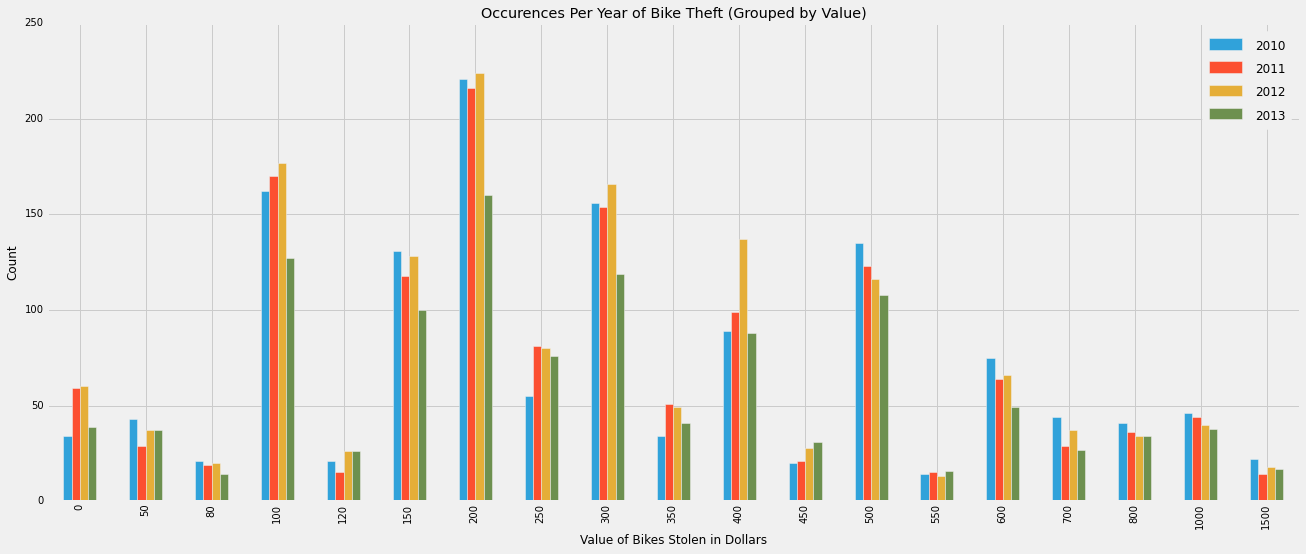

In [66]:
with plt.style.context('fivethirtyeight'):
    ax = merged.plot(kind='bar')
    ax.set_title("Occurences Per Year of Bike Theft (Grouped by Value)")
    ax.set_xlabel("Value of Bikes Stolen in Dollars")
    ax.set_ylabel("Count")

##### Notes:
* Judging by the increase in 2011 and 2012 in the 0 value, it seems like there were more unsuccessful attempts during those years then in 2010 and 2013
* This graph reinforces our knowledge that 200 dollar bikes are either a favorite for theives or for police reports.
* Bike thefts of 500 dollars or more have been on the decline. This could be to a variety of reasons
    * Greater investment in locks and awareness by owners
    * Less 500 dollar bikes out on the streets than previous years
    * Owners learning from previous mistakes, to name a few

### Thefts Per Season
* aka the number of bike thefts per season
* Going to create a new column for this as it's not in the dataframe yet

In [67]:
time_df["Season"] = time_df['Theft Month'].apply(lambda x: "Winter" if x in ['12','01','02'] 
else "Spring" if x in ['03','04','05']
else "Summer" if x in ['06','07','08']
else "Fall")


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


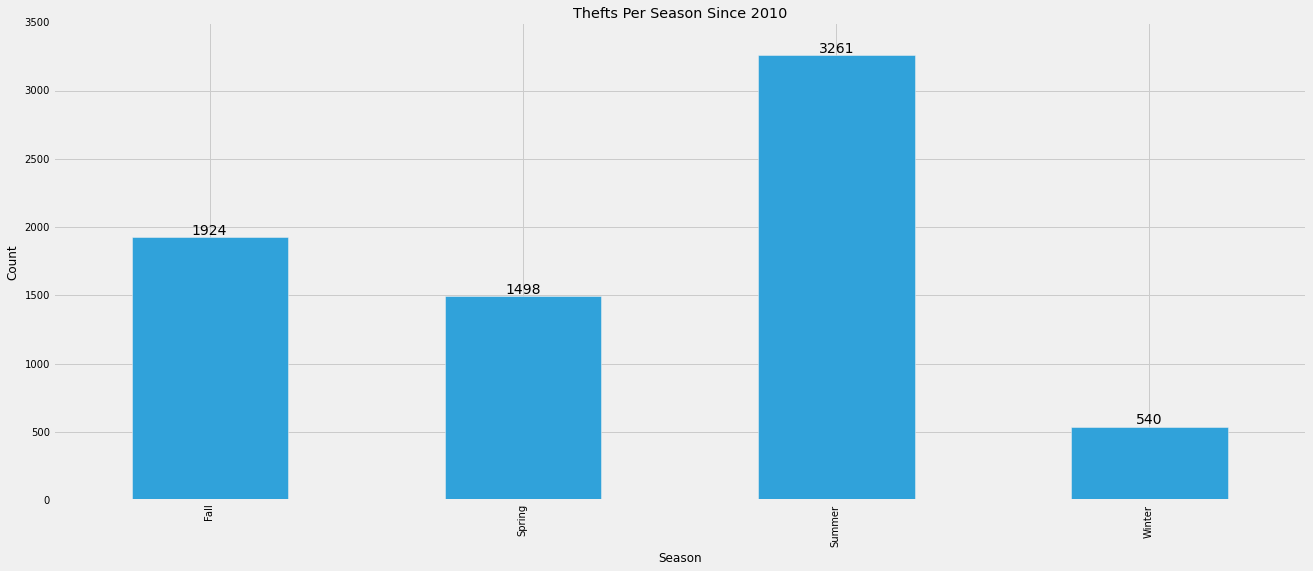

In [69]:
with plt.style.context('fivethirtyeight'):
    thefts_season = time_df.groupby(time_df['Season'])
    ax = thefts_season["Total Thefts on Date"].count().plot(kind='bar')
    ax.set_title("Thefts Per Season Since 2010")
    ax.set_xlabel("Season")
    ax.set_ylabel("Count")
    # plt.ylim(0,11)
    values = thefts_season["Total Thefts on Date"].count()
    labels = [i for i in values]
    rects = ax.patches

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height+.5, label, ha='center', va='bottom')

##### Pivot Table showing the number of thefts per hour, per season

In [70]:
hours_season=pd.pivot_table(time_df,index=["Theft Hour"],columns=["Season"], values="Location"
               , aggfunc=len,fill_value=0)
pd.pivot_table(time_df,index=["Theft Hour"],columns=["Season"], values="Location"
               , aggfunc='count',fill_value=0)

Season,Fall,Spring,Summer,Winter
Theft Hour,,,,
0,35,32,70,7
1,31,24,48,10
2,16,12,38,5
3,7,6,29,6
4,10,5,22,1
5,8,4,18,1
6,10,2,19,0
7,22,19,53,4
8,43,23,107,13


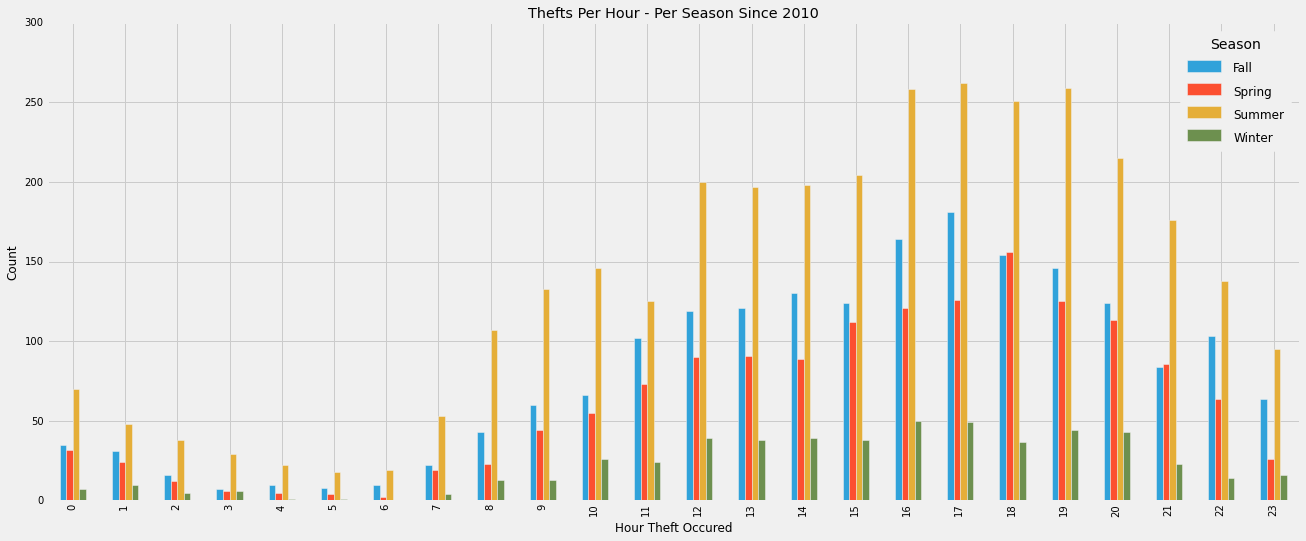

In [71]:
with plt.style.context('fivethirtyeight'):
    ax = hours_season.plot(kind='bar')
    ax.set_title("Thefts Per Hour - Per Season Since 2010")
    ax.set_xlabel("Hour Theft Occured")
    ax.set_ylabel("Count")

### Scatterplot

[[<matplotlib.axes._subplots.AxesSubplot object at 0x10be3bdd0>


/Library/Python/2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


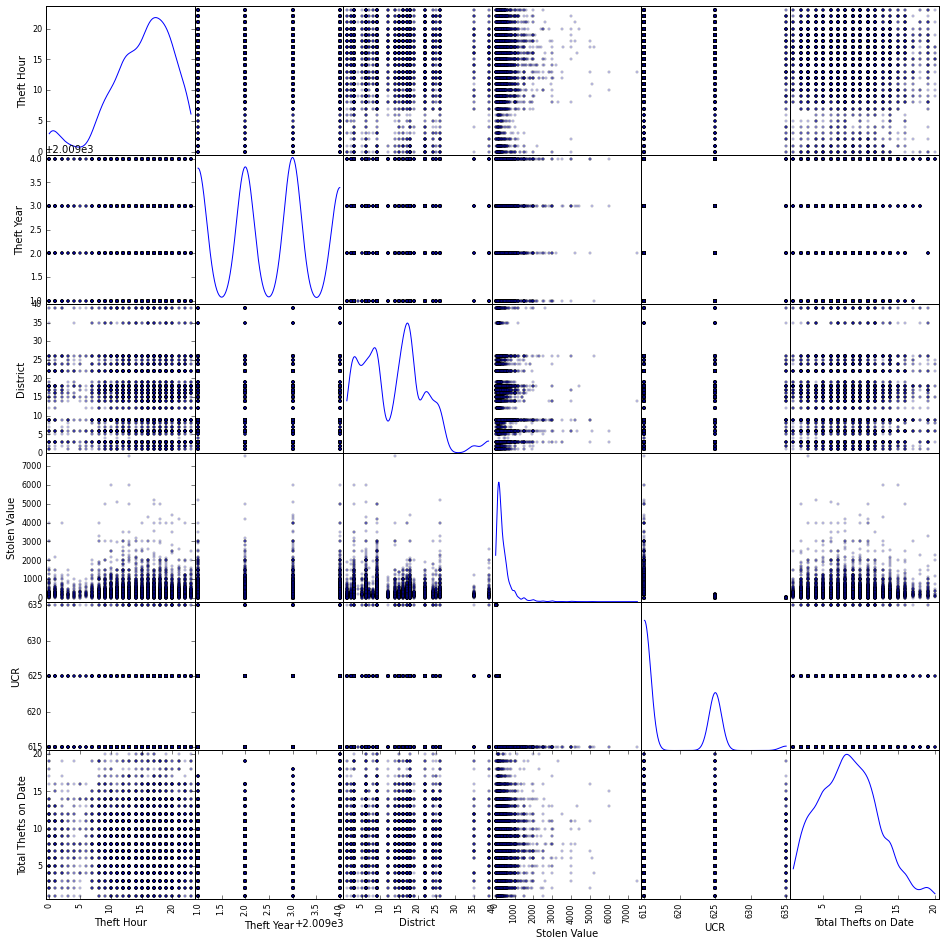

In [72]:
from pandas.tools.plotting import scatter_matrix
print scatter_matrix(time_df, alpha=0.2, figsize=(16, 16), diagonal='kde')

In [73]:
time_df.corr()

,Theft Hour,Theft Year,District,Stolen Value,UCR,Total Thefts on Date
Theft Hour,1.000000,-0.008338,-0.025306,-0.035447,0.023999,0.005195
Theft Year,-0.008338,1.000000,0.023795,0.025381,-0.014844,0.153290
District,-0.025306,0.023795,1.000000,-0.108860,0.099023,0.008342
Stolen Value,-0.035447,0.025381,-0.108860,1.000000,-0.423839,0.003023
UCR,0.023999,-0.014844,0.099023,-0.423839,1.000000,0.002568
Total Thefts on Date,0.005195,0.153290,0.008342,0.003023,0.002568,1.000000


##### Notes:
    * Nothing strong either direction here

##### Let's see if there's a correlation between seasons and any of the variables
* We'll first binarize the seasons column, then find the correlation coefficients for each variable and that season

In [78]:
time_df2 = time_df
del time_df2['Theft Date']
time_df2 = time_df2.reset_index()
time_df2.head()

,Theft Date,Location,Theft Hour,Theft Day,Theft Month,Theft Year,District,Stolen Value,UCR,Total Thefts on Date,Season
0,2010-04-16,2100 BLOCK S BROAD ST,0,16,04,2010,1,150,625,4,Spring
1,2010-04-24,S 2100 MCKEAN ST,17,24,04,2010,1,215,615,7,Spring
2,2010-06-06,2700 BLOCK SNYDER AVE,11,06,06,2010,1,120,625,8,Summer
3,2010-07-08,2100 BLOCK S GARNET ST,15,08,07,2010,1,200,615,10,Summer
4,2010-07-11,2100 BLOCK S 15TH ST,11,11,07,2010,1,75,625,9,Summer


In [79]:
binarize = pd.DataFrame(time_df2.values[:,-1])

binary_dicts = [dict(r.iteritems()) for _, r in binarize.iterrows()]

from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
binarize_vec = vec.fit_transform(binary_dicts).toarray()

binarize_vec =  binarize_vec.tolist()
binarize_vec = DataFrame(binarize_vec)
# print binarize_vec
time_df2 = pd.concat([time_df2,binarize_vec], axis=1)


In [80]:
time_df2.columns=['Theft Date','Location','Theft Hour','Theft Day','Theft Month','Theft Year','District','Stolen Value'
                 ,'UCR','Total Thefts On Date','Season','Fall','Spring','Summer','Winter']

In [81]:
time_df2.corr()

,Theft Hour,Theft Year,District,Stolen Value,UCR,Total Thefts On Date,Fall,Spring,Summer,Winter
Theft Hour,1.000000,-0.008338,-0.025306,-0.035447,0.023999,0.005195,0.018982,0.026719,-0.039415,0.001486
Theft Year,-0.008338,1.000000,0.023795,0.025381,-0.014844,0.153290,-0.180411,0.033921,0.124045,0.016234
District,-0.025306,0.023795,1.000000,-0.108860,0.099023,0.008342,-0.010570,-0.014138,0.023355,-0.004629
Stolen Value,-0.035447,0.025381,-0.108860,1.000000,-0.423839,0.003023,0.008004,0.013150,-0.012450,-0.010167
UCR,0.023999,-0.014844,0.099023,-0.423839,1.000000,0.002568,-0.020384,-0.006867,0.027386,-0.006971
Total Thefts On Date,0.005195,0.153290,0.008342,0.003023,0.002568,1.000000,0.010251,-0.317724,0.453433,-0.385390
Fall,0.018982,-0.180411,-0.010570,0.008004,-0.020384,0.010251,1.000000,-0.308229,-0.546668,-0.171284
Spring,0.026719,0.033921,-0.014138,0.013150,-0.006867,-0.317724,-0.308229,1.000000,-0.464073,-0.145405
Summer,-0.039415,0.124045,0.023355,-0.012450,0.027386,0.453433,-0.546668,-0.464073,1.000000,-0.257887
Winter,0.001486,0.016234,-0.004629,-0.010167,-0.006971,-0.385390,-0.171284,-0.145405,-0.257887,1.000000


##### Notes:
* Total Thefts Per Day is correlated with the Summer Months (.45 coeff).  This is a moderate correlation, but very close to strong

# PMFs

* Probability Mass Function
* Whereas a histogram plots a count for values, a PMF plots a probability for values
* Probability of having exactly a certain number
* If you want Probability of having at least that number, add all probs to the left
* Good for small sample size

In [82]:
def eval_pdf(rv, num=3):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

In [83]:
def EvalCdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1
    prob = count / len(sample)
    return prob

In [84]:
import thinkstats2
import thinkplot
import scipy.stats
import math

In [85]:
# del time_df["Theft Date"]
time_df = time_df.reset_index()

In [86]:
time_df["Theft Hour"].describe()

count    7223.000000
mean       14.883705
std         5.243005
min         0.000000
25%        12.000000
50%        16.000000
75%        19.000000
max        23.000000
Name: Theft Hour, dtype: float64

### Theft Hour

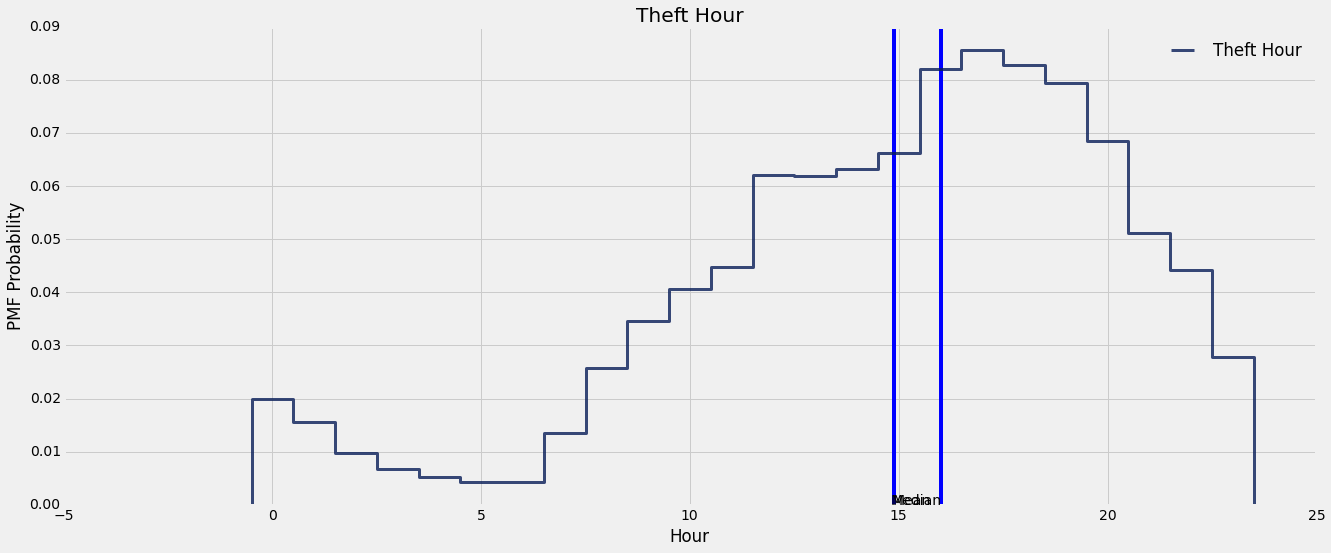

In [88]:
with plt.style.context('fivethirtyeight'):
    std = time_df["Theft Hour"].std()
    mean = time_df["Theft Hour"].mean()
    median = time_df["Theft Hour"].median()
    pmf = thinkstats2.Pmf(time_df["Theft Hour"])
    plt.title(str("Theft Hour"))
    plt.axvline(x=mean)
    plt.text(mean,0,'Mean',rotation=0, horizontalalignment='left')
    #         plt.text(0,0,'Mean: %f'%round(mean),rotation=0, horizontalalignment='left')
    plt.axvline(x=median)
    plt.text(median,0,'Median',rotation=0, horizontalalignment='right')
    #         plt.text(0,0,'Median: %f'%round(median),rotation=0, horizontalalignment='right')
    thinkplot.Pmf(pmf, label=str("Theft Hour"))
    thinkplot.Show(xlabel="Hour", ylabel="PMF Probability")

In [89]:
# PMF Probabilities for given hour
pmf

Pmf({0: 0.019936314550740689, 1: 0.015644469057178458, 2: 0.0098297106465457564, 3: 0.0066454381835802301, 4: 0.0052609718953343489, 5: 0.0042918454935622317, 6: 0.0042918454935622317, 7: 0.013567769624809637, 8: 0.02575107296137339, 9: 0.034611657206147034, 10: 0.040564862245604322, 11: 0.04485670773916655, 12: 0.062024089713415484, 13: 0.061885643084590894, 14: 0.06313166274401219, 15: 0.066177488578153129, 16: 0.08209885089298076, 17: 0.085560016613595469, 18: 0.082791084037103696, 19: 0.079468364945313591, 20: 0.068531081268171118, 21: 0.051086806036273018, 22: 0.044164474595043614, 23: 0.027827772393742213})

###### Note:
* If your bike was to be stolen, you have a 31% chance that it'll happen between 3pm and 7pm.
    * Add individual probabilities for 15,16,17

### Theft Day

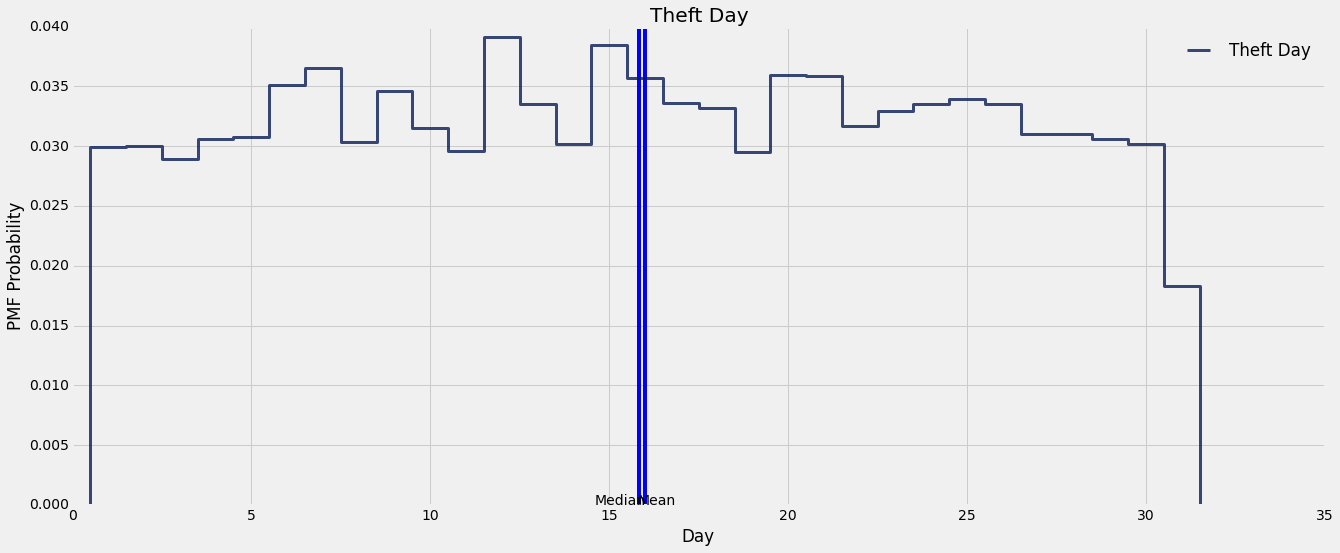

In [90]:
with plt.style.context('fivethirtyeight'):
    std = time_df["Theft Day"].astype(int).std()
    mean = time_df["Theft Day"].astype(int).mean()
    median = time_df["Theft Day"].astype(int).median()
    pmf = thinkstats2.Pmf(time_df["Theft Day"].astype(int))
    plt.title(str("Theft Day"))
    plt.axvline(x=mean)
    plt.text(mean,0,'Mean',rotation=0, horizontalalignment='left')
    #         plt.text(0,0,'Mean: %f'%round(mean),rotation=0, horizontalalignment='left')
    plt.axvline(x=median)
    plt.text(median,0,'Median',rotation=0, horizontalalignment='right')
    #         plt.text(0,0,'Median: %f'%round(median),rotation=0, horizontalalignment='right')
    thinkplot.Pmf(pmf, label=str("Theft Day"))
    thinkplot.Show(xlabel="Day", ylabel="PMF Probability")

### Theft Month

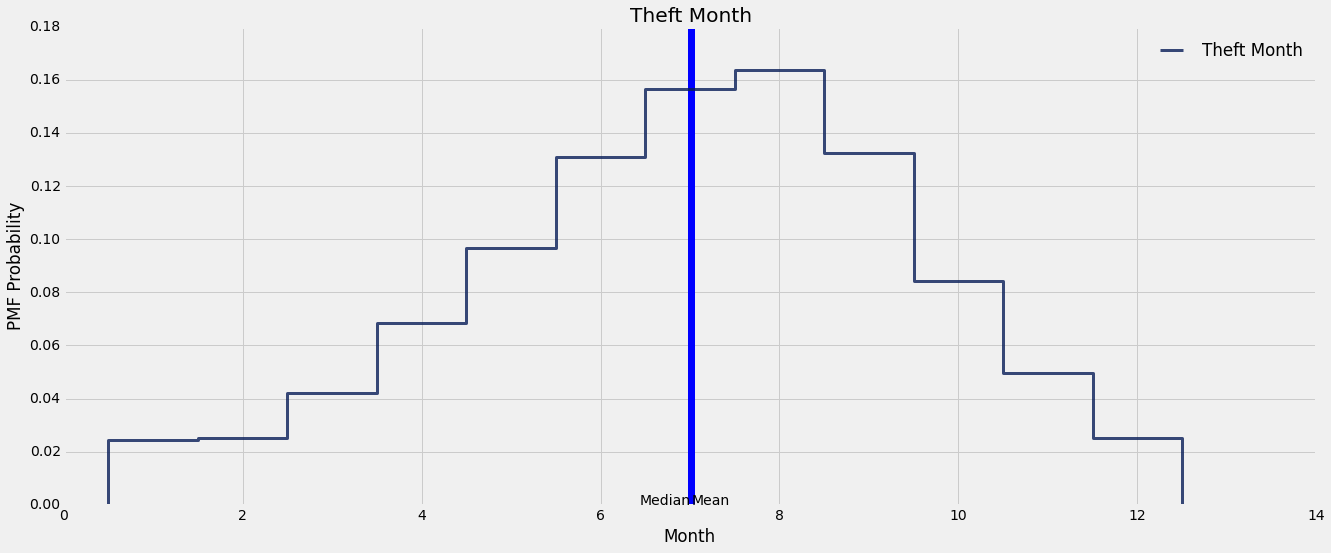

In [91]:
with plt.style.context('fivethirtyeight'):
    std = time_df["Theft Month"].astype(int).std()
    mean = time_df["Theft Month"].astype(int).mean()
    median = time_df["Theft Month"].astype(int).median()
    pmf = thinkstats2.Pmf(time_df["Theft Month"].astype(int))
    plt.title(str("Theft Month"))
    plt.axvline(x=mean)
    plt.text(mean,0,'Mean',rotation=0, horizontalalignment='left')
    plt.axvline(x=median)
    plt.text(median,0,'Median',rotation=0, horizontalalignment='right')
    thinkplot.Pmf(pmf, label=str("Theft Month"))
    thinkplot.Show(xlabel="Month", ylabel="PMF Probability")

In [92]:
pmf

Pmf({1: 0.024505053301952098, 2: 0.025058839817250451, 3: 0.042226221791499381, 4: 0.068531081268171118, 5: 0.096635746919562518, 6: 0.13110895749688495, 7: 0.15672158382943377, 8: 0.16364391527066316, 9: 0.13249342378513085, 10: 0.084175550325349582, 11: 0.049702339748027138, 12: 0.025197286446075037})

##### Notes:
    * ~16 Percent chance of a bike theft happening in August vs other months, if your bike was stolen
    * ~45 Percent chance of it happening in the summer

# CDF

* Cumulative Distribution Function
* Percentile for having a certain count of a feature
    * Eg. If there were 12 thefts on a day, ~85% of days have less thefts than this 12 theft day, so it's in the 85th Percentile for Theft Count
    * Also think of it like the SAT: If you get a 1300 and they tell you that you're in the 95% Percentile, that means that your score is higher than 95% of other test takers
* It also allows for a visual representation of the shape of the graph

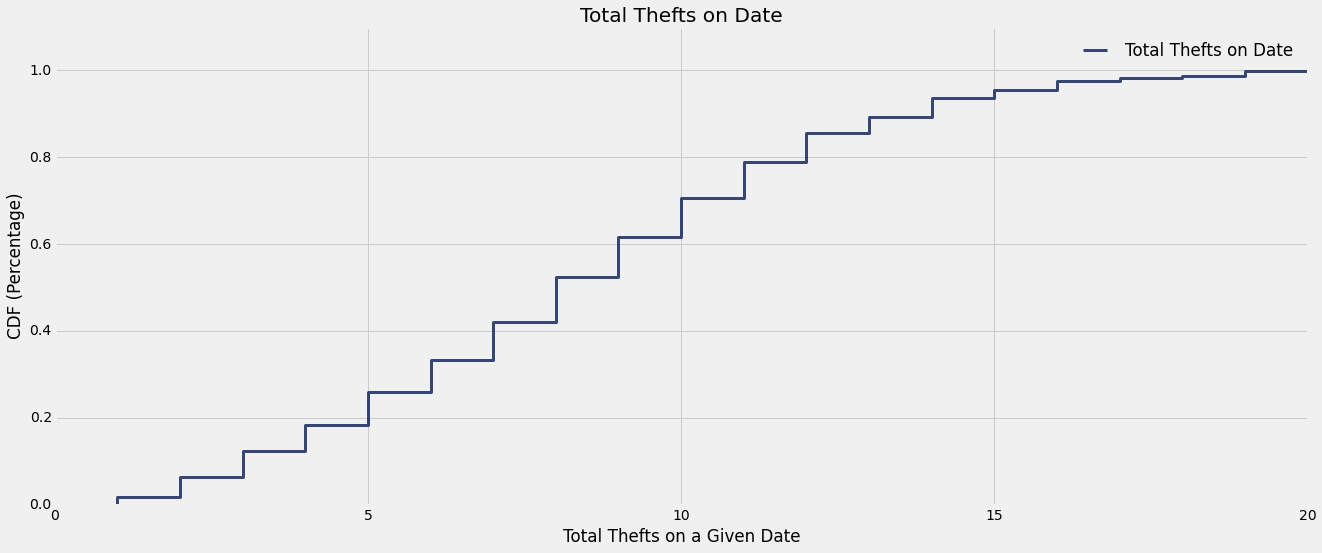

Median: 8.000000 
Low IQR: 5.000000  High IQR: 11.000000


In [94]:
with plt.style.context('fivethirtyeight'):
    std = time_df['Total Thefts on Date'].std()
    mean = time_df['Total Thefts on Date'].mean()
    cdf = thinkstats2.Cdf(time_df['Total Thefts on Date'], label=str('Total Thefts on Date'))
    median =  cdf.Value(0.5)
    iqr = [cdf.Percentile(25), cdf.Percentile(75)]
    plt.title(str('Total Thefts on Date'))
    plt.ylim(0,1.1)
    thinkplot.Cdf(cdf)
    thinkplot.Show(xlabel="Total Thefts on a Given Date", ylabel="CDF (Percentage)")
    print "Median: %f "% median
    print "Low IQR: %f" % iqr[0], " High IQR: %f" % iqr[1]

##### Notes:
* This is saying that if there were 11 thefts tomorrow, tomorrow's theft count would be in the 80th percentile of theft counts.  In other words, 80% of all other days with recorded theft counts are lower

# Let's Test Significance
* Let's see if the average number of times a theft occurs during the summer is significantly different from the rest of the seasons
* A statistically significant result (in our case the difference) is a result that’s not attributed to chance. More technically, it means that if the Null Hypothesis is true (which means there really is no difference), there’s a low probability of getting a result that large or larger.

In [95]:
summer = time_df.loc[time_df['Season'] == "Summer"]
rest = time_df.loc[time_df['Season'] != "Summer"]

In [96]:
import hypothesis
import nsfg, nsfg2, first

In [97]:
data = (summer["Total Thefts on Date"],
        rest["Total Thefts on Date"])
ht = hypothesis.DiffMeansPermute(data)
# Number of simulations
p_value = ht.PValue(iters=10000)
print('p-value =', p_value)
print('actual difference in means =', ht.actual)
print('test sample max difference =', ht.MaxTestStat())

('p-value =', 0.0)
('actual difference in means =', 3.6008893751603122)
('test sample max difference =', 0.39416607417816607)


##### Notes:
* If our Null Hypothesis is that we expect to find no difference between total theft counts in the summer vs the other seasons, we should see a high p-value.
* Our p-value is remarkably low, which allows us to conclude that our null hypothesis is unlikely to be true
* Our simulation never yields an effect as big as the actual difference, thus we conclude that the difference is statistically significant
* The pvalue is therefore significant.  So in this example I conclude that the data do provide evidence that the difference in average times a theft occurs in the summer is statistically significant
* It's important to note though that "statistically significant" doesn't always mean that the difference/effect is important in practice.  It just means that the difference/effect is unlikely to have occured by chance